<a href="https://colab.research.google.com/github/RishikaSamala/IU_AML/blob/main/Copy_of_Mnist_hand_digit_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required libraries new

import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as data

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# load MNIST dataset

train_dataset = datasets.MNIST('sample_data//MNIST' ,train=True,download=True,transform=transforms.ToTensor())
test_dataset = datasets.MNIST('sample_data//MNIST' ,train=False,download=True,transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting sample_data//MNIST/MNIST/raw/train-images-idx3-ubyte.gz to sample_data//MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting sample_data//MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data//MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting sample_data//MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data//MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting sample_data//MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data//MNIST/MNIST/raw



In [ ]:
# split

train_split,valid_split = data.random_split(train_dataset,[54000,6000])

In [ ]:

# dataloaders 

train_loader = torch.utils.data.DataLoader(train_split, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_split, batch_size=64, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

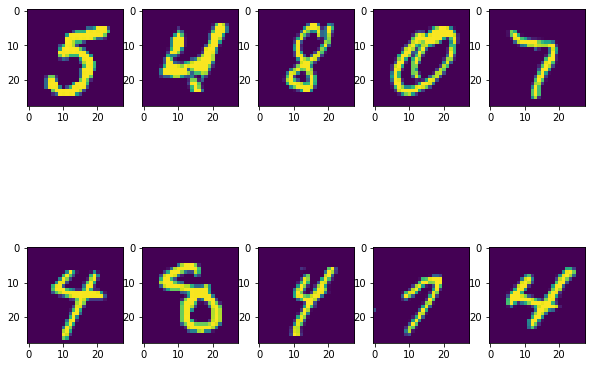

In [ ]:
# plot few images in train data

train_iter = iter(train_loader)
(images,labels) = train_iter.next()
(images,labels) = train_iter.next()

plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0])
plt.show()

In [ ]:
# Build CNN Model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv1.weight = self.weight_init_xavier_cnn(12,1,8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=4)
        self.conv2.weight = self.weight_init_xavier_cnn(12,12,4)
        self.fc1 = nn.Linear(18*18*12, 30)
        self.fc1.weight = self.weight_init_xavier_fc(30,3888)
        self.fc2 = nn.Linear(30, 10)
        self.fc2.weight = self.weight_init_xavier_fc(10,30)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def weight_init_xavier_cnn(self,feature_maps_num,input_feature_maps,kernel_size): 
        weight = nn.init.xavier_uniform_(torch.randn(feature_maps_num,input_feature_maps,kernel_size,kernel_size), gain=1.0)
        return nn.parameter.Parameter(weight)

    def weight_init_xavier_fc(self,out_nodes,inp_nodes):
        weight = nn.init.xavier_uniform_(torch.randn(out_nodes,inp_nodes), gain=1.0)
        return nn.parameter.Parameter(weight)
 


In [ ]:
# training process

cnn = CNN()
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr = 0.05,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.9)
val_losses = []
train_losses = []

for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_loader):
        
        # reshape images 
        #images = images.reshape(-1,1,28,28)
        
        # calculate oputput -> forward pass
        outputs = cnn(images.float())
        
        # calculate loss for this batch
        loss = loss_func(outputs,labels)
        
        # perform backward popagation
        optimizer.zero_grad()    
        loss.backward()
        
        # update weights using gradients
        optimizer.step()
        
    # change learning rate
    if epoch % 10 == 0:
        scheduler.step()
        print(scheduler.get_last_lr())
    
    #--------calculate validation loss------#
    
    val_images = train_dataset.data[val_loader.dataset.indices].reshape(-1,1,28,28)
    val_labels = train_dataset.targets[val_loader.dataset.indices]
    outputs_val = cnn(val_images.float())
    val_loss = loss_func(outputs_val,val_labels)
    val_losses.append(val_loss.item())
    
    #-------------------------------------#
    
    train_losses.append(loss.item())
    
    print('Epoch : {} =>>  train_loss = {:.3f}, val_loss = {:.3f}'.format(epoch,loss.item(),val_loss.item()))
    
    
    

[0.05]
Epoch : 0 =>>  train_loss = 0.158, val_loss = 16.334
Epoch : 1 =>>  train_loss = 0.096, val_loss = 22.771
Epoch : 2 =>>  train_loss = 0.020, val_loss = 14.308
Epoch : 3 =>>  train_loss = 0.004, val_loss = 15.369
Epoch : 4 =>>  train_loss = 0.003, val_loss = 22.758
Epoch : 5 =>>  train_loss = 0.029, val_loss = 22.618
Epoch : 6 =>>  train_loss = 0.033, val_loss = 21.259
Epoch : 7 =>>  train_loss = 0.001, val_loss = 22.043
Epoch : 8 =>>  train_loss = 0.051, val_loss = 41.290
Epoch : 9 =>>  train_loss = 0.003, val_loss = 36.390
[0.045000000000000005]
Epoch : 10 =>>  train_loss = 0.036, val_loss = 33.133
Epoch : 11 =>>  train_loss = 0.044, val_loss = 28.443
Epoch : 12 =>>  train_loss = 0.017, val_loss = 37.497
Epoch : 13 =>>  train_loss = 0.000, val_loss = 39.545
Epoch : 14 =>>  train_loss = 0.000, val_loss = 28.291
Epoch : 15 =>>  train_loss = 0.000, val_loss = 41.176
Epoch : 16 =>>  train_loss = 0.149, val_loss = 34.912
Epoch : 17 =>>  train_loss = 0.000, val_loss = 56.288
Epoch : 

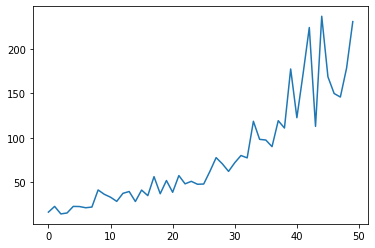

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(50),val_losses)

plt.show()

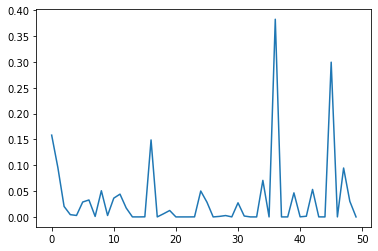

In [ ]:

plt.plot(range(50),train_losses)
plt.show()

In [ ]:
# Test data evaluation

test_images = test_dataset.data.reshape(-1,1,28,28).float()
test_labels = test_dataset.targets
test_outputs = cnn(test_images)
test_pred = torch.argmax(test_outputs,dim=1)
loss = loss_func(test_outputs,test_labels)

#outputs = model(test_dataset.data.reshape(-1,1,28,28).float())

In [ ]:
test_outputs[2],test_pred[2],test_labels[2]

(tensor([    0.0000, 13509.1699,  6013.4263,     0.0000,     0.0000,     0.0000,
             0.0000,  1389.5887,     0.0000,     0.0000],
        grad_fn=<SelectBackward0>), tensor(1), tensor(1))

In [ ]:
y_pred=torch.argmax(outputs,dim=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels ,test_pred)

0.936

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       980
           1       0.98      0.95      0.96      1135
           2       0.95      0.94      0.94      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.93      0.94       982
           5       0.94      0.89      0.91       892
           6       0.86      0.98      0.92       958
           7       0.93      0.95      0.94      1028
           8       0.96      0.91      0.93       974
           9       0.90      0.91      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels,test_pred)

array([[ 908,    0,    1,    0,    2,    7,   42,   15,    1,    4],
       [   2, 1080,   15,    1,    1,    0,   25,    1,   10,    0],
       [  16,    1,  965,   13,    4,    3,   10,    9,    8,    3],
       [   0,    3,    3,  973,    2,    3,    1,    9,    3,   13],
       [   0,    5,    2,    0,  909,    6,   13,    4,    3,   40],
       [   2,    3,    0,    7,    2,  796,   51,    9,    4,   18],
       [   3,    2,    1,    1,    2,    9,  940,    0,    0,    0],
       [   4,    2,   20,    5,    6,    1,    0,  977,    1,   12],
       [  15,    6,   14,   16,    4,   11,    8,    3,  889,    8],
       [   6,    4,    0,    2,   19,   15,    3,   27,   10,  923]])

((torch.Size([54000, 28, 28]), torch.Size([54000])),
 (torch.Size([6000, 28, 28]), torch.Size([6000])))

torch.Size([54000])

In [ ]:
op = optim.Adam(cnn.parameters(),lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(op,step_size=2,gamma = 0.9)

for i in range(100):
    scheduler.step()
    print(scheduler.get_last_lr())

[0.05]
[0.045000000000000005]
[0.045000000000000005]
[0.04050000000000001]
[0.04050000000000001]
[0.03645000000000001]
[0.03645000000000001]
[0.03280500000000001]
[0.03280500000000001]
[0.02952450000000001]
[0.02952450000000001]
[0.02657205000000001]
[0.02657205000000001]
[0.02391484500000001]
[0.02391484500000001]
[0.021523360500000012]
[0.021523360500000012]
[0.01937102445000001]
[0.01937102445000001]
[0.01743392200500001]
[0.01743392200500001]
[0.015690529804500006]
[0.015690529804500006]
[0.014121476824050006]
[0.014121476824050006]
[0.012709329141645007]
[0.012709329141645007]
[0.011438396227480507]
[0.011438396227480507]
[0.010294556604732457]
[0.010294556604732457]
[0.00926510094425921]
[0.00926510094425921]
[0.00833859084983329]
[0.00833859084983329]
[0.007504731764849962]
[0.007504731764849962]
[0.006754258588364966]
[0.006754258588364966]
[0.00607883272952847]
[0.00607883272952847]
[0.005470949456575623]
[0.005470949456575623]
[0.0049238545109180605]
[0.0049238545109180605]
[

C:\Users\siris\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
